# Analyzing Football Player Scores with Sorare Data

## Preparing Data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from requests import get as get
from requests import post as post
import json
import bcrypt

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA


### API Authentication

Get player stats from Sorare, a Fantasy Football website that provides stats and scores for each player in major leagues through a GraphQL API. 

Authenticate

In [3]:
email = "maite.marzoratti@gmail.com"

r = get(f'https://api.sorare.com/api/v1/users/{email}')
response = json.loads(r.content)
cookies={"_sorare_session_id":r.cookies['_sorare_session_id']}
# get salt and hash with password
salt = response['salt'].encode('utf8')
pwrd = "s.r6yZBkaxbbX:7".encode('utf8')
hashed = bcrypt.hashpw(pwrd, salt).decode('utf8')
csrf = r.headers["CSRF-TOKEN"]

headers = {
    "x-csrf-token": csrf
}

# login
url = 'https://api.sorare.com/graphql'
login_query = """
mutation SignInMutation($input: signInInput!) {
  signIn(input: $input) {
    currentUser {
      slug
      __typename
    }
    otpSessionChallenge
    errors {
      path
      message
      __typename
    }
    __typename
  }
}
"""

variables = {
  "input": {
    "email": email,
    "password": hashed
  }
}

p = post(url, json={'query': login_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)


In [4]:
# # Write your query or mutation here
# player_query="""
# query {
#   player(slug: "rodrigo-javier-de-paul") {
#     id
#     displayName
#     activeClub {
#       name
#       slug
#     }
#     activeClub {
#       name
#     }
#     status {
#       lastFiveSo5AverageScore
#       lastFifteenSo5AverageScore
#     }
#   }
# }"""

# t=post(url, json={'query': player_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
#         headers=headers,cookies=cookies)
# t1=t.json()['data']['player']

# pd.json_normalize(t1)

### Sorare API Query

Query to get all players from Spains's La Liga

In [42]:
clubs_query="""
query{
    competition(slug:"primera-division-es") {
    clubs {
      nodes {
        slug
      }
    }
  }
}

"""

clubs=post(url, json={'query': clubs_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)

slugs=pd.json_normalize(clubs.json()['data'])
slugs=slugs.loc[0].iloc[0]

club_slugs=[]
for i in slugs:
    club_slugs.append(i['slug'])

In [43]:
clubs_query="""query{
    competition(slug:"ligue-1-fr") {
    clubs {
      nodes {
        slug
      }
    }
  }
}"""

clubs=post(url, json={'query': clubs_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)
slugs=pd.json_normalize(clubs.json()['data'])
slugs=slugs.loc[0].iloc[0]

for i in slugs:
    club_slugs.append(i['slug'])

In [45]:
len(club_slugs)

40

In [54]:
i=0

players_query="""
query playerQuery($club:String!){
  club(slug:$club) {
        name
        slug
        activePlayers {
          nodes {
            displayName
            slug
            status {
              lastFiveSo5Appearances
              lastFiveSo5AverageScore
              lastFifteenSo5Appearances
              lastFifteenSo5AverageScore
              playingStatus
            }
            lastClub {
              name
              activeCompetitions {
                name
              }
            }
            allSo5Scores (first:5) {
              nodes {
                position
                score
                detailedScore {
                  category
                  points
                  stat
                  statValue
                  totalScore
                }
              }
            }
       }
     }
   }

 }"""






In [63]:
player_df=pd.DataFrame()
for i in range(0,len(club_slugs)):
    variables = {
        "club":club_slugs[i]
        }
    active_players_r=post(url, json={'query': players_query, 'OperationName': 'SignInMutation', 'variables': variables}, 
        headers=headers,cookies=cookies)

    player_df=player_df.append(pd.json_normalize(active_players_r.json()['data']))

In [68]:
club_df=player_df.reset_index(drop=True)

In [69]:
club_df.shape

(40, 3)

### Response Clean Up

Create a dataframe with the data provided in json by the API

Expand players

In [72]:
club_df.head()

,club.name,club.slug,club.activePlayers.nodes
0,CA Osasuna,osasuna-pamplona-irunea,"[{'displayName': 'Arrasate', 'slug': 'jagoba-a..."
1,Real Madrid CF,real-madrid-madrid,"[{'displayName': 'Rodrygo', 'slug': 'rodrygo-s..."
2,Granada CF,granada-granada,"[{'displayName': 'Luis Suárez', 'slug': 'luis-..."
3,Cádiz CF,cadiz-cadiz,"[{'displayName': 'Álex', 'slug': 'alejandro-fe..."
4,Sevilla FC,sevilla-sevilla-1890,"[{'displayName': 'Antonio Zarzana', 'slug': 'a..."


In [73]:
club_df.explode(column='club.activePlayers.nodes').reset_index(drop=True)


,club.name,club.slug,club.activePlayers.nodes
0,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Arrasate', 'slug': 'jagoba-ar..."
1,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Kike', 'slug': 'enrique-garci..."
2,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Sergio Herrera', 'slug': 'ser..."
3,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Roberto Torres', 'slug': 'rob..."
4,CA Osasuna,osasuna-pamplona-irunea,"{'displayName': 'Jonás Ramalho', 'slug': 'jona..."
...,...,...,...
1362,Stade Brestois 29,brest-brest,"{'displayName': 'Rafiki Said Ahamada', 'slug':..."
1363,Stade Brestois 29,brest-brest,"{'displayName': 'Franck Honorat', 'slug': 'fra..."
1364,Stade Brestois 29,brest-brest,"{'displayName': 'Romain Del Castillo', 'slug':..."
1365,Stade Brestois 29,brest-brest,"{'displayName': 'Gautier Larsonneur', 'slug': ..."


In [75]:
# laliga_data=laliga_r.json()['data']['competition']['clubs']['nodes']
# df_laliga=pd.json_normalize(laliga_data)
df_laliga_players=club_df.explode(column='club.activePlayers.nodes').reset_index(drop=True)
A=pd.json_normalize(df_laliga_players['club.activePlayers.nodes'])
df_laliga_players=df_laliga_players.drop(columns='club.activePlayers.nodes').join(A,how='left',rsuffix='_player',lsuffix='_club')
df_laliga_players.head()


,club.name,club.slug,displayName,slug,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",[]
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Forward', 'score': 68.6, 'detai..."
2,CA Osasuna,osasuna-pamplona-irunea,Sergio Herrera,sergio-herrera-piron,5,41.240000,14,46.964286,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Goalkeeper', 'score': 20.2, 'de..."
3,CA Osasuna,osasuna-pamplona-irunea,Roberto Torres,roberto-torres-morales,4,26.825000,11,39.018182,substitute,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Midfielder', 'score': 28.3, 'de..."
4,CA Osasuna,osasuna-pamplona-irunea,Jonás Ramalho,jonas-ramalho-chimeno,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...","[{'position': 'Defender', 'score': None, 'deta..."


In [76]:
df_laliga_players.shape

(1367, 12)

In [79]:
df_laliga_players.rename(columns={'slug':'slug_player','club.slug':'slug'},inplace=True)
pd.json_normalize(df_laliga_players[df_laliga_players.slug_player=='luka-modric']['allSo5Scores.nodes'])

,0,1,2,3,4
0,"{'position': 'Midfielder', 'score': 54.1, 'det...","{'position': 'Midfielder', 'score': 56.1, 'det...","{'position': 'Midfielder', 'score': None, 'det...","{'position': 'Midfielder', 'score': None, 'det...","{'position': 'Midfielder', 'score': 61.2, 'det..."


Expand player scores (all)

In [80]:
a=df_laliga_players.explode('allSo5Scores.nodes').reset_index(drop=True)
a[a.slug_player=='luka-modric']

,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,allSo5Scores.nodes
279,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","{'position': 'Midfielder', 'score': 54.1, 'det..."
280,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","{'position': 'Midfielder', 'score': 56.1, 'det..."
281,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","{'position': 'Midfielder', 'score': None, 'det..."
282,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","{'position': 'Midfielder', 'score': None, 'det..."
283,Real Madrid CF,real-madrid-madrid,Luka Modrić,luka-modric,3,55.8,12,64.425,starter,Real Madrid CF,"[{'name': 'Primera División'}, {'name': 'UEFA ...","{'position': 'Midfielder', 'score': 61.2, 'det..."


In [81]:
df_laliga_player_scores=df_laliga_players.explode('allSo5Scores.nodes').reset_index(drop=True)
pd.json_normalize(df_laliga_player_scores['allSo5Scores.nodes'])

,position,score,detailedScore
0,NaN,NaN,NaN
1,Forward,68.6,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
2,Forward,NaN,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3,Forward,33.2,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
4,Forward,0.0,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
...,...,...,...
6449,Midfielder,65.6,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
6450,Midfielder,26.2,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
6451,Midfielder,34.6,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
6452,Midfielder,79.1,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."


In [82]:
df_laliga_player_scores=df_laliga_players.explode('allSo5Scores.nodes').reset_index(drop=True)
B=pd.json_normalize(df_laliga_player_scores['allSo5Scores.nodes'])
df_laliga_player_scores=df_laliga_player_scores.drop(columns='allSo5Scores.nodes').join(B,how='left')
df_laliga_player_scores.head()

,club.name,slug,displayName,slug_player,status.lastFiveSo5Appearances,status.lastFiveSo5AverageScore,status.lastFifteenSo5Appearances,status.lastFifteenSo5AverageScore,status.playingStatus,lastClub.name,lastClub.activeCompetitions,position,score,detailedScore
0,CA Osasuna,osasuna-pamplona-irunea,Arrasate,jagoba-arrasate-elustondo,0,0.000000,0,0.000000,not_playing,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",NaN,NaN,NaN
1,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,68.6,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
2,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,NaN,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
3,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,33.2,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."
4,CA Osasuna,osasuna-pamplona-irunea,Kike,enrique-garcia-martinez,3,48.466667,13,41.015385,starter,CA Osasuna,"[{'name': 'Primera División'}, {'name': 'Copa ...",Forward,0.0,"[{'category': 'UNKNOWN', 'points': 0.0, 'stat'..."


In [83]:
df_laliga_player_scores[df_laliga_player_scores.slug_player=='luka-modric'][['slug_player','position','score']]

,slug_player,position,score
279,luka-modric,Midfielder,54.1
280,luka-modric,Midfielder,56.1
281,luka-modric,Midfielder,NaN
282,luka-modric,Midfielder,NaN
283,luka-modric,Midfielder,61.2


Add detailed score

Sorare uses it's own system to calculate each player's score from different stats:  https://draftgym.com/sorare-new-scoring-system-explained. For the following analysis we will be using the stat value and not the calulated score, as it represents better the player's playing style. 

In [84]:
df_laliga_player_scores['detailedScore']

0                                                     NaN
1       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
2       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
3       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
4       [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
                              ...                        
6449    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6450    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6451    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6452    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
6453    [{'category': 'UNKNOWN', 'points': 0.0, 'stat'...
Name: detailedScore, Length: 6454, dtype: object

In [85]:
df_laliga_player_scores['detailedScore'].iloc[8][8]

{'category': 'PASSING',
 'points': -0.2,
 'stat': 'missed_pass',
 'statValue': 13.0,
 'totalScore': -2.6}

In [86]:
total=0
for i in range(len(df_laliga_player_scores.iloc[2]['detailedScore'])):
    total=total+df_laliga_player_scores.iloc[2]['detailedScore'][i]['totalScore']
total

25.0

In [87]:
#detailed stats to columns
df_stats=pd.DataFrame()

for j_player in range(df_laliga_player_scores.shape[0]):
    if df_laliga_player_scores.iloc[j_player]['detailedScore']==df_laliga_player_scores.iloc[j_player]['detailedScore']:
        df_stat_i=pd.DataFrame()
        for i in range(len(df_laliga_player_scores.iloc[j_player]['detailedScore'])):
            index=df_laliga_player_scores.index[j_player]
            stat_name=df_laliga_player_scores.iloc[j_player]['detailedScore'][i]['stat']
            stat_value=df_laliga_player_scores.iloc[j_player]['detailedScore'][i]['statValue']
            df_stat_i=pd.concat([df_stat_i,pd.DataFrame(index=[index],columns=[stat_name],data=[stat_value])],axis=1)
        df_stats=df_stats.append(df_stat_i)
df_stats.head(10)

,level_score,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,...,long_pass_own_to_opp_success,goal_assist,red_card,assist_penalty_won,penalty_conceded,penalty_save,error_lead_to_goal,last_man_tackle,clearance_off_line,own_goals
1,0.0,90.0,1.0,1.0,0.0,0.0,0.0,0.0,17.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,68.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,90.0,0.0,5.0,0.0,0.0,0.0,0.0,16.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,90.0,1.0,NaN,0.0,NaN,NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,22.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.0,90.0,0.0,NaN,0.0,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
df_laliga_player_scores_detailed=df_laliga_player_scores.join(df_stats,how='left')
df_laliga_player_scores_detailed.drop(columns='detailedScore',inplace=True)
df_laliga_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   club.name                          6454 non-null   object 
 1   slug                               6454 non-null   object 
 2   displayName                        6454 non-null   object 
 3   slug_player                        6454 non-null   object 
 4   status.lastFiveSo5Appearances      6454 non-null   int64  
 5   status.lastFiveSo5AverageScore     6454 non-null   float64
 6   status.lastFifteenSo5Appearances   6454 non-null   int64  
 7   status.lastFifteenSo5AverageScore  6454 non-null   float64
 8   status.playingStatus               6399 non-null   object 
 9   lastClub.name                      6454 non-null   object 
 10  lastClub.activeCompetitions        6454 non-null   object 
 11  position                           6406 non-null   objec

In [89]:
df_laliga_player_scores_detailed.loc[:,df_laliga_player_scores_detailed.dtypes=='float64']=df_laliga_player_scores_detailed.loc[:,df_laliga_player_scores_detailed.dtypes=='float64'].fillna(0)

In [90]:
df_laliga_player_scores_detailed[df_laliga_player_scores_detailed.slug_player=='karim-benzema'].iloc[:,12:]

,score,level_score,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,...,long_pass_own_to_opp_success,goal_assist,red_card,assist_penalty_won,penalty_conceded,penalty_save,error_lead_to_goal,last_man_tackle,clearance_off_line,own_goals
259,93.1,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,45.0,0.0,90.0,0.0,2.0,0.0,0.0,0.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261,84.3,0.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262,58.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
263,65.7,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
df_laliga_player_scores_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   club.name                          6454 non-null   object 
 1   slug                               6454 non-null   object 
 2   displayName                        6454 non-null   object 
 3   slug_player                        6454 non-null   object 
 4   status.lastFiveSo5Appearances      6454 non-null   int64  
 5   status.lastFiveSo5AverageScore     6454 non-null   float64
 6   status.lastFifteenSo5Appearances   6454 non-null   int64  
 7   status.lastFifteenSo5AverageScore  6454 non-null   float64
 8   status.playingStatus               6399 non-null   object 
 9   lastClub.name                      6454 non-null   object 
 10  lastClub.activeCompetitions        6454 non-null   object 
 11  position                           6406 non-null   objec

In [92]:
df_laliga_player_scores_detailed.dtypes[12:]

score                            float64
level_score                      float64
mins_played                      float64
yellow_card                      float64
was_fouled                       float64
error_lead_to_shot               float64
double_double                    float64
triple_double                    float64
triple_triple                    float64
poss_lost_ctrl                   float64
duel_lost                        float64
duel_won                         float64
big_chance_created               float64
adjusted_total_att_assist        float64
accurate_pass                    float64
successful_final_third_passes    float64
ontarget_scoring_att             float64
won_contest                      float64
pen_area_entries                 float64
penalty_kick_missed              float64
big_chance_missed                float64
saves                            float64
saved_ibox                       float64
good_high_claim                  float64
punches         

In [93]:
df_laliga_player_scores_detailed[df_laliga_player_scores_detailed.slug_player=='luka-modric']['position']

279    Midfielder
280    Midfielder
281    Midfielder
282    Midfielder
283    Midfielder
Name: position, dtype: object

In [98]:
df_laliga_player_scores_detailed.rename(columns={'slug':'slug_club','club.name':'name'},inplace=True)
df_laliga_player_scores_detailed[['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','level_score']].groupby(['name','slug_club','displayName','slug_player','status.lastFiveSo5Appearances','displayName'])['level_score'].mean()

name           slug_club              displayName          slug_player                  status.lastFiveSo5Appearances  displayName        
AS Monaco FC   monaco-monaco          Aleksandr Golovin    aleksandr-golovin            4                              Aleksandr Golovin      0.0
                                      Alexander Nübel      alexander-nubel              4                              Alexander Nübel        0.0
                                      Aurélien Platret     aurelien-platret             0                              Aurélien Platret       0.0
                                      Aurélien Tchouaméni  aurelien-tchouameni          5                              Aurélien Tchouaméni    0.0
                                      Axel Disasi          axel-disasi                  4                              Axel Disasi            0.0
                                                                                                                                   

In [99]:
df_laliga_player_scores_detailed.drop(columns=['lastClub.name','lastClub.activeCompetitions'])
df_laliga_player_scores_grouped=df_laliga_player_scores_detailed.groupby(['name','slug_club','displayName','slug_player',
'status.lastFiveSo5Appearances','status.lastFiveSo5AverageScore','status.lastFifteenSo5Appearances','status.lastFifteenSo5AverageScore',
'status.playingStatus','position']).mean().reset_index()

In [100]:
df_laliga_player_scores_detailed[df_laliga_player_scores_detailed.slug_player=='aitor-paredes-casamichana'][['mins_played','score','level_score']]

,mins_played,score,level_score
2026,0.0,0.0,0.0
2027,0.0,0.0,0.0
2028,0.0,0.0,0.0
2029,0.0,0.0,0.0
2030,0.0,0.0,0.0


In [101]:
df_laliga_player_scores_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               1294 non-null   object 
 1   slug_club                          1294 non-null   object 
 2   displayName                        1294 non-null   object 
 3   slug_player                        1294 non-null   object 
 4   status.lastFiveSo5Appearances      1294 non-null   int64  
 5   status.lastFiveSo5AverageScore     1294 non-null   float64
 6   status.lastFifteenSo5Appearances   1294 non-null   int64  
 7   status.lastFifteenSo5AverageScore  1294 non-null   float64
 8   status.playingStatus               1294 non-null   object 
 9   position                           1294 non-null   object 
 10  score                              1294 non-null   float64
 11  level_score                        1294 non-null   float

## Exploratory Analysis

status

In [102]:
df_laliga_player_scores_grouped['status.playingStatus'].value_counts()

not_playing    561
starter        421
substitute     225
regular         87
Name: status.playingStatus, dtype: int64

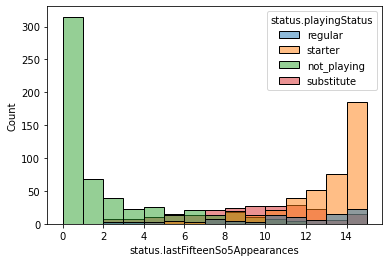

In [103]:
sns.histplot(data=df_laliga_player_scores_grouped,x='status.lastFifteenSo5Appearances',binwidth=1,hue='status.playingStatus');

Stats

In [104]:
stat_columns=df_laliga_player_scores_grouped.columns[12:]

Scale stats with min max scaler so that they can be compared. Visualize average stats by position to understand differences.

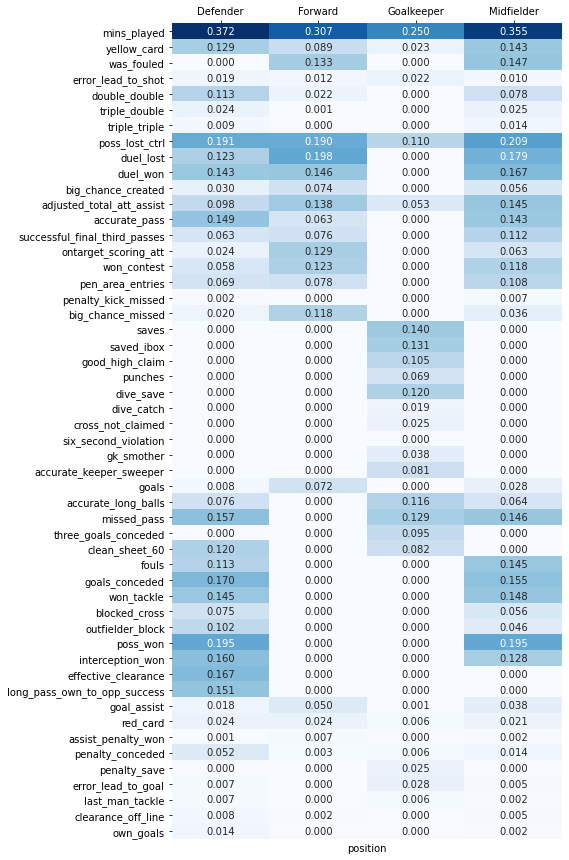

In [105]:
scaler_minmax=MinMaxScaler()
stats_scaled=scaler_minmax.fit_transform(df_laliga_player_scores_grouped[stat_columns])

df_stats_minmax=pd.DataFrame(data=stats_scaled,columns=stat_columns)
df_stats_minmax['position']=df_laliga_player_scores_grouped['position']

plt.figure(figsize=(7,15))
sns.heatmap(df_stats_minmax.groupby('position')[stat_columns].mean().T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


## Clustering

Identify different groups of players by making clusters with stats.

### PCA

Reducing dimensionality with PCA

In [106]:
mask_starter=df_laliga_player_scores_grouped['status.playingStatus']=='starter'
mask_regular=df_laliga_player_scores_grouped['status.playingStatus']=='regular'

X=df_laliga_player_scores_grouped[mask_starter|mask_regular]
X=X.iloc[:,12:]
print(X.shape)


scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

pca_df = PCA()
pca_df.fit(X_scaled)
pca_df.explained_variance_ratio_.round(2)

(508, 52)


array([0.18, 0.14, 0.08, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [107]:
pd.Series(pca_df.explained_variance_ratio_).cumsum()

0     0.177491
1     0.312606
2     0.396919
3     0.435742
4     0.466207
5     0.494206
6     0.520127
7     0.545190
8     0.569465
9     0.592531
10    0.614824
11    0.636121
12    0.656992
13    0.677273
14    0.696834
15    0.715189
16    0.733414
17    0.750687
18    0.767570
19    0.783698
20    0.798899
21    0.813663
22    0.828284
23    0.842476
24    0.855368
25    0.867524
26    0.879523
27    0.890511
28    0.900508
29    0.909999
30    0.918682
31    0.926626
32    0.933908
33    0.941010
34    0.947545
35    0.953619
36    0.959313
37    0.964523
38    0.969596
39    0.973864
40    0.977906
41    0.981653
42    0.984996
43    0.988124
44    0.991068
45    0.993379
46    0.995527
47    0.997411
48    0.998771
49    0.999698
50    1.000000
51    1.000000
dtype: float64

In [108]:
pca_loadings = pd.DataFrame(pca_df.components_.T, index=X.columns).iloc[:,:10]
pca_loadings.style.background_gradient(axis=None,cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9
mins_played,-0.025244,-0.114113,0.324404,0.218153,0.220488,-0.016453,-0.037503,0.059880,-0.059071,-0.070707
yellow_card,-0.077875,-0.060560,0.042481,-0.126257,0.166578,-0.090955,-0.176840,-0.032313,-0.238267,0.193620
was_fouled,-0.146815,0.191568,0.151406,-0.172152,0.106600,-0.023166,-0.019548,0.104920,0.023615,-0.100580
error_lead_to_shot,0.039325,-0.027724,0.037430,0.129476,0.029409,0.065580,0.151668,-0.027444,0.180345,-0.542533
double_double,-0.099398,-0.180482,0.051985,-0.097950,0.008723,-0.011013,-0.244645,0.036048,0.027296,-0.021040
triple_double,-0.044384,-0.096385,0.000251,-0.176982,0.162229,0.012943,0.176988,-0.127988,0.097642,0.106969
triple_triple,-0.029001,-0.044916,0.038935,-0.166575,-0.074663,-0.006823,-0.173606,0.269092,0.455730,0.144140
poss_lost_ctrl,-0.110897,0.032920,0.366722,0.061579,0.016101,-0.005376,-0.038734,0.035380,-0.053247,-0.137691
duel_lost,-0.218086,0.113805,0.091737,-0.054919,0.269303,-0.045430,-0.060555,0.077161,-0.150581,-0.166120
duel_won,-0.245189,-0.021726,0.141105,-0.086043,0.250597,-0.038796,-0.194688,0.082179,-0.008533,-0.134315


### Cluster

In [109]:
def Search_Kmeans(X_scaled):
    k_values=range(2,20)
    sq_distances=[] 
    sil=[]
    ch_scores=[]
    for k in k_values:
        kmeans=KMeans(n_clusters=k,n_init=10,random_state=0)
        kmeans.fit(X_scaled)
        sq_distances.append(kmeans.inertia_)
        score=silhouette_score(X_scaled,kmeans.labels_)
        sil.append(score)
        score=calinski_harabasz_score(X_scaled,kmeans.labels_)
        ch_scores.append(score)

    fig, axs = plt.subplots(1,3,figsize=(20,5))
    axs[0].set(xlabel = "Número de clusters", ylabel = "Suma Distancias Cuadráticas", title = "Inercia Score")
    axs[1].set(xlabel = "Número de clusters", ylabel = "Silhouette score", title = "Silhouette Score")
    axs[2].set(xlabel = "Número de clusters", ylabel = "Calinski-Harabasz Score", title = "Calinski-Harabasz Score")
    sns.lineplot(ax=axs[0],x=k_values,y=sq_distances,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[1],x=k_values,y=sil,marker='o',size=30,legend=False )
    sns.lineplot(ax=axs[2],x=k_values,y=ch_scores,marker='o',size=30,legend=False )
    axs[0].grid(color='gray', linewidth=1, ls='--')
    axs[1].grid(color='gray', linewidth=1, ls='--')
    axs[2].grid(color='gray', linewidth=1, ls='--')

In [110]:
X.shape

(508, 52)

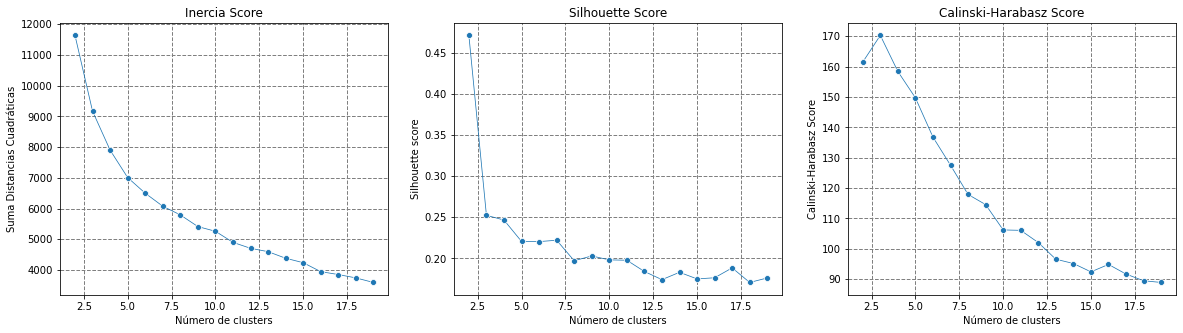

In [111]:
n_components=10
df_pca = pd.DataFrame(pca_df.transform(X_scaled)[:,:n_components], index=X.index)
df_pca.head(5)

Search_Kmeans(df_pca)

Clustering with 5 clusters, and calculate distance to each centroid

In [124]:
n_clusters=4
kmeans=KMeans(n_clusters=n_clusters,random_state=1)
kmeans.fit(df_pca)

df_output=df_laliga_player_scores_grouped.loc[X.index]
df_output['label']=kmeans.labels_

dist_clusters=kmeans.transform(df_pca)
df_dist_clusters=pd.DataFrame(index=df_pca.index,data=dist_clusters)
dist_col_names=['dist_cluster_'+str(i) for i in df_dist_clusters.columns]
df_output[dist_col_names]=df_dist_clusters


### Cluster Analysis

Visualize which positions are included in each cluster

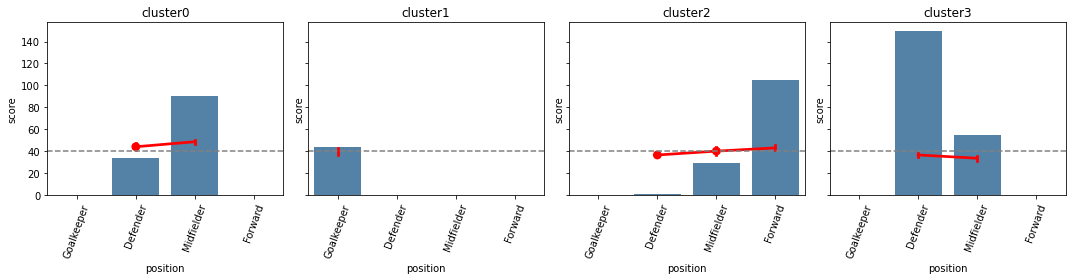

In [114]:

positions=['Goalkeeper','Defender','Midfielder','Forward']
labels=range(0,n_clusters)

n_plots=df_output['label'].nunique()
max_col=n_clusters
max_row=int(np.ceil(n_plots/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(15,4),squeeze=False,sharey=True)
for i in range(n_plots):
    df=df_output[df_output.label==i]
    sns.countplot(data=df,x='position',ax=ax[n_row,n_col],color='steelblue',order=positions)
    sns.pointplot(data=df,x='position',y='score',ax=ax[n_row,n_col],color='red',order=positions)
    ax[n_row,n_col].axhline(40, ls='--',color='gray')
    ax[n_row,n_col].set_xticklabels(ax[n_row,n_col].get_xticklabels(),rotation=70)

    ax[n_row,n_col].set_title('cluster'+str(i))
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.tight_layout()

The clusters are mainly grouping by position. Something interesting is that there are players that seem to be "misclassified", for example defenders in the midfielders cluster(cluster2), or midfielders in the forwards cluster (cluster1). We will try to identify if these players have a playing style more similar than those in the other position and why.

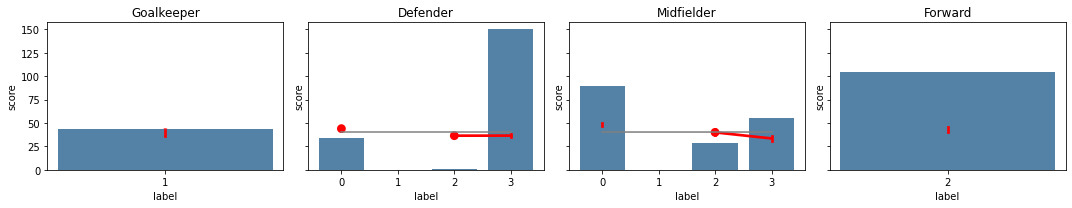

In [115]:


n_plots=df_output['label'].nunique()
max_col=4
max_row=int(np.ceil(len(positions)/max_col))

n_row=0
n_col=0
fig,ax=plt.subplots(max_row,max_col,figsize=(15,3),squeeze=False,sharey=True)
for i in positions:
    df=df_output[df_output.position==i].copy()
    sns.countplot(data=df,x='label',ax=ax[n_row,n_col],color='steelblue',order=labels)
    sns.pointplot(data=df,x='label',y='score',ax=ax[n_row,n_col],color='red',order=labels)
    sns.lineplot(x=df.label,y=np.ones(df.label.shape[0])*40,ax=ax[n_row,n_col],color='gray')

    ax[n_row,n_col].set_title(str(i))
    n_col+=1
    if(n_col==max_col):
        n_col=0
        n_row+=1
plt.tight_layout()

Give names to each cluster

In [125]:
df_output['label_name']=df_output.label.map({0:'Mid',1:'Goalkeeper',2:'Offensive',3:'Defensive'})

df_output.rename(columns={
    'dist_cluster_0':'dist_midfielder',
    'dist_cluster_1':'dist_goalkeeper',
    'dist_cluster_2':'dist_offensive',
    'dist_cluster_3':'dist_defensive',
},inplace=True)

dist_col_names=['dist_midfielder','dist_goalkeeper',
    'dist_offensive','dist_defensive']

In [117]:
df_output['label_name'].value_counts()

Defensive     205
Offensive     135
Mid           124
Goalkeeper     44
Name: label_name, dtype: int64

Scale stats so that they can be compared, and visualize how stat values are distributed between clusters.

In [118]:
cluster_stats=df_output.groupby('label_name')[stat_columns].mean()
cluster_stats

,mins_played,yellow_card,was_fouled,error_lead_to_shot,double_double,triple_double,triple_triple,poss_lost_ctrl,duel_lost,duel_won,...,long_pass_own_to_opp_success,goal_assist,red_card,assist_penalty_won,penalty_conceded,penalty_save,error_lead_to_goal,last_man_tackle,clearance_off_line,own_goals
label_name,,,,,,,,,,,,,,,,,,,,,
Defensive,61.514146,0.146341,0.147317,0.017561,0.148943,0.034146,0.000976,7.198049,2.578862,2.918049,...,3.037073,0.016585,0.006829,0.000976,0.018537,0.000000,0.004878,0.000976,0.007805,0.004878
Goalkeeper,75.045455,0.050000,0.000000,0.031818,0.000000,0.000000,0.000000,8.390909,0.000000,0.000000,...,0.000000,0.004545,0.000000,0.000000,0.004545,0.013636,0.040909,0.004545,0.000000,0.000000
Mid,76.793548,0.187097,0.993548,0.006452,0.196774,0.035484,0.011290,12.830645,4.648387,5.059677,...,0.769355,0.106452,0.008065,0.009677,0.004839,0.000000,0.004839,0.001613,0.003226,0.003226
Offensive,59.509630,0.105185,0.933333,0.011852,0.034074,0.001481,0.000000,9.260741,4.438519,3.496296,...,0.004444,0.111111,0.005926,0.004444,0.001481,0.000000,0.000000,0.000000,0.001481,0.000000


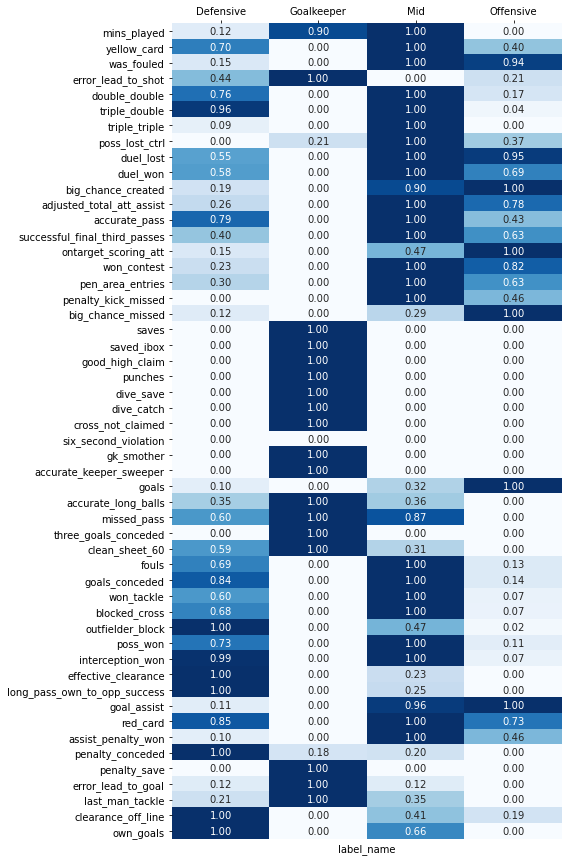

In [119]:
scaler=MinMaxScaler()
cluster_scaled=scaler.fit_transform(cluster_stats)

df_cluster_scaled=pd.DataFrame(data=cluster_scaled,columns=stat_columns,index=cluster_stats.index)

plt.figure(figsize=(7,15))
sns.heatmap(df_cluster_scaled.T,annot=True,cbar=False,fmt='.2f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')


Visualize how each PCA component is included in each cluster

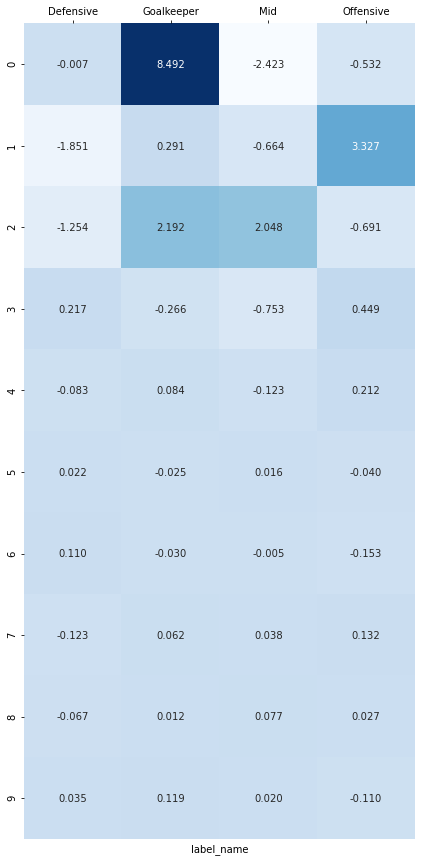

In [120]:
output_pca=df_pca.copy()
output_pca['label_name']=df_output['label_name']
cluster_pca=output_pca.groupby('label_name').mean()

plt.figure(figsize=(7,15))
sns.heatmap(cluster_pca.T,annot=True,cbar=False,fmt='.3f',cmap='Blues')
plt.gca().xaxis.set_ticks_position('top')

In [122]:
df_output.slug_club.unique()

array(['monaco-monaco', 'saint-etienne-saint-etienne',
       'angers-sco-angers', 'athletic-club-bilbao',
       'osasuna-pamplona-irunea', 'clermont-clermont-ferrand',
       'atletico-madrid-madrid', 'cadiz-cadiz',
       'deportivo-alaves-vitoria-gasteiz', 'elche-elche', 'troyes-troyes',
       'barcelona-barcelona', 'bordeaux-le-haillan', 'lorient-ploemeur',
       'metz-metz', 'nantes-la-chapelle-sur-erdre',
       'getafe-getafe-madrid', 'granada-granada', 'levante-valencia',
       'lille-villeneuve-d-ascq', 'montpellier-montpellier', 'nice-nice',
       'olympique-lyonnais-lyon', 'olympique-marseille-marseille',
       'psg-paris', 'strasbourg-strasbourg', 'lens-avion',
       'rayo-vallecano-madrid', 'real-betis-sevilla',
       'celta-de-vigo-vigo', 'mallorca-palma-de-mallorca',
       'real-madrid-madrid', 'real-sociedad-donostia-san-sebastian',
       'espanyol-barcelona', 'sevilla-sevilla-1890', 'brest-brest',
       'rennes-rennes', 'reims-reims', 'valencia-valencia',
  

Check how players in best known clubs (Barcelona, Atletico de Madrid and Real Madrid) are being classified.

In [128]:
col_names=['label_name','slug_player','score','position','slug_club','mins_played','dist_midfielder','dist_offensive',
    'dist_goalkeeper','dist_defensive']
df_output_dists=df_output[col_names].sort_values(by='label_name')
df_output_dists[df_output_dists.slug_club.isin(['psg-paris','real-madrid-madrid','atletico-madrid-madrid','barcelona-barcelona'])][col_names].sort_values(by='label_name')

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_goalkeeper,dist_defensive
356,Defensive,clement-lenglet,28.10,Defender,barcelona-barcelona,31.6,5.405714,4.808713,9.550615,2.790437
199,Defensive,felipe-augusto-de-almeida-monteiro,37.34,Defender,atletico-madrid-madrid,54.2,5.180541,5.341174,9.745335,2.101924
213,Defensive,mario-hermoso-canseco,41.74,Defender,atletico-madrid-madrid,90.0,5.032984,7.343073,10.383128,3.122922
212,Defensive,marcos-llorente-moreno,27.20,Midfielder,atletico-madrid-madrid,44.0,5.262243,4.583511,9.555089,3.167207
999,Defensive,david-olatukunbo-alaba,43.46,Defender,real-madrid-madrid,72.0,6.770732,6.633735,9.904203,4.081757
774,Defensive,abdou-diallo,24.44,Defender,psg-paris,36.0,6.071402,5.844339,9.368463,1.924089
797,Defensive,marcos-aoas-correa,65.56,Defender,psg-paris,90.0,9.539089,10.841992,12.780264,8.069710
1026,Defensive,eder-gabriel-militao,57.72,Defender,real-madrid-madrid,90.0,6.369784,9.313275,11.742768,5.679607
801,Defensive,nuno-mendes,29.46,Defender,psg-paris,39.2,5.125489,3.649922,9.140280,2.995909
380,Defensive,ronald-federico-araujo-da-silva,49.28,Defender,barcelona-barcelona,72.0,3.191106,5.993478,10.578256,2.942684


Check players with biggest distance from all clusters. These are the most dis-similar players

In [130]:
df_output_dists['min_dist']=df_output_dists[dist_col_names].apply(min,axis=1)
mask_max=df_output_dists['min_dist']>df_output_dists['min_dist'].quantile(0.95)
df_output_dists[mask_max].sort_values(by='min_dist',ascending=False)

,label_name,slug_player,score,position,slug_club,mins_played,dist_midfielder,dist_offensive,dist_goalkeeper,dist_defensive,min_dist
292,Goalkeeper,edgar-badia-guardiola,54.54,Goalkeeper,elche-elche,90.0,20.244701,19.982353,13.396419,19.633822,13.396419
1276,Goalkeeper,geronimo-rulli,58.26,Goalkeeper,villarreal-villarreal,90.0,20.117514,19.819285,12.931835,19.443904,12.931835
584,Mid,jose-angel-gomez-campana,46.06,Midfielder,levante-valencia,82.8,11.484964,12.765888,16.452122,12.676065,11.484964
567,Goalkeeper,luis-manuel-arantes-maximiano,42.14,Goalkeeper,granada-granada,90.0,15.721907,15.382199,11.289787,14.940886,11.289787
1152,Goalkeeper,marco-bizot,38.20,Goalkeeper,brest-brest,90.0,17.092178,16.576349,10.986747,16.260869,10.986747
1237,Offensive,goncalo-manuel-ganchinho-guedes,54.74,Midfielder,valencia-valencia,71.6,10.589759,10.387048,15.245277,11.866031,10.387048
726,Mid,malo-gusto,36.46,Defender,olympique-lyonnais-lyon,71.0,9.798632,12.099168,14.583158,10.639320,9.798632
235,Goalkeeper,jeremias-ledesma,41.20,Goalkeeper,cadiz-cadiz,90.0,18.320886,18.198511,9.472022,17.747248,9.472022
795,Offensive,lionel-andres-messi-cuccittini,70.16,Forward,psg-paris,90.0,10.065057,9.438307,16.330269,12.918231,9.438307
655,Goalkeeper,jonas-omlin,62.42,Goalkeeper,montpellier-montpellier,90.0,16.799415,16.159199,9.430037,15.709355,9.430037


Using distance to each cluster as a proxy for similarity with a position, we can visualize how each player's playing style resembles the one of defenders, midfielders and forwards. We can also understand which players are more different than everyone else by looking at players with larger distances to cluster centroids. For example Lionel Messi is one of the players most separeted from the rest. This means that his stats are far away from the others.

In [131]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_defensive',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Offensive and defensive similarity')

In [132]:
px.scatter(df_output_dists[df_output_dists.position!='Goalkeeper'],
x='dist_midfielder',y='dist_offensive',
color='label_name',hover_data=['slug_club','slug_player','mins_played','position','score'],
title='Midfielder and offensive similarity')

In [136]:
metric='accurate_pass'
df_laliga_player_scores_grouped.sort_values(by=metric,ascending=False)[['slug_club','slug_player','position','score',metric]].head(20)

,slug_club,slug_player,position,score,accurate_pass
1023,real-madrid-madrid,toni-kroos,Midfielder,78.58,95.0
772,olympique-marseille-marseille,william-saliba,Defender,66.12,94.8
797,psg-paris,marcos-aoas-correa,Defender,65.56,75.6
656,montpellier-montpellier,jordan-ferri,Midfielder,53.92,73.0
771,olympique-marseille-marseille,valentin-rongier,Midfielder,44.66,63.8
323,troyes-troyes,florian-tardieu,Midfielder,62.04,62.0
176,clermont-clermont-ferrand,johan-gastien,Midfielder,46.72,60.6
743,olympique-marseille-marseille,boubacar-kamara,Defender,45.52,60.0
705,olympique-lyonnais-lyon,bruno-guimaraes-rodriguez-moura,Midfielder,50.94,59.4
1026,real-madrid-madrid,eder-gabriel-militao,Defender,57.72,58.8


In [ ]:
toni_kroos=df_laliga_player_scores_grouped[df_laliga_player_scores_grouped.slug_player=='toni-kroos']
toni_kroos.loc[483].iloc[3:]

slug_player                          toni-kroos
status.lastFiveSo5Appearances                 5
status.lastFiveSo5AverageScore            82.96
status.lastFifteenSo5Appearances             15
status.lastFifteenSo5AverageScore          78.7
status.playingStatus                    starter
position                             Midfielder
score                                     82.96
level_score                                 0.0
mins_played                                86.6
yellow_card                                 0.0
was_fouled                                  1.4
error_lead_to_shot                          0.0
double_double                               0.2
triple_double                               0.2
triple_triple                               0.0
poss_lost_ctrl                              9.8
duel_lost                                   1.6
duel_won                                    3.0
big_chance_created                          0.2
adjusted_total_att_assist               

In [137]:
df_player_stats_scaled=pd.DataFrame(index=X.index,columns=X.columns,data=X_scaled)
df_player_stats_scaled=df_player_stats_scaled.join(df_output[['slug_club','slug_player','label_name','position','score']],how='left')

In [140]:
df_laliga_player_scores_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               1294 non-null   object 
 1   slug_club                          1294 non-null   object 
 2   displayName                        1294 non-null   object 
 3   slug_player                        1294 non-null   object 
 4   status.lastFiveSo5Appearances      1294 non-null   int64  
 5   status.lastFiveSo5AverageScore     1294 non-null   float64
 6   status.lastFifteenSo5Appearances   1294 non-null   int64  
 7   status.lastFifteenSo5AverageScore  1294 non-null   float64
 8   status.playingStatus               1294 non-null   object 
 9   position                           1294 non-null   object 
 10  score                              1294 non-null   float64
 11  level_score                        1294 non-null   float